# Julia is fast

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself.  One can read the notebook and see what happened on the author's Macbook Pro with a 4-core Intel Core I7, or run the notebook yourself.

(This material began life as a wonderful lecture by Steven Johnson at MIT: https://github.com/stevengj/18S096/blob/master/lectures/lecture1/Boxes-and-registers.ipynb.)

# Outline of this notebook

- Define the sum function
- Implementations & benchmarking of sum in...
    - C (hand-written)
    - C (hand-written with -ffast-math)
    - python (built-in)
    - python (numpy)
    - python (hand-written)
    - Julia (built-in)
    - Julia (hand-written)
    - Julia (hand-written with SIMD)
- Summary of benchmarks

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [1]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

10000000-element Vector{Float64}:
 0.6448151016314798
 0.3375510491023963
 0.756260526969947
 0.5320115530937721
 0.19485757498069156
 0.8316695966128653
 0.3618371465671122
 0.04988232126798309
 0.11672360089074973
 0.10911647583260486
 0.15569281234527654
 0.5346569743322791
 0.7831128123089823
 ⋮
 0.8114201281897417
 0.2284619017045788
 0.6195793506380749
 0.7281320521430599
 0.8252621599889354
 0.007700057733918131
 0.27275468580714946
 0.7337134679733959
 0.6031429079365416
 0.6185445094461164
 0.3358820556872182
 0.6703294587119144

In [2]:
sum(a)

4.9997820410244325e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

In [3]:
@time sum(a)

  0.004394 seconds (1 allocation: 16 bytes)


4.9997820410244325e6

In [4]:
@time sum(a)

  0.005274 seconds (1 allocation: 16 bytes)


4.9997820410244325e6

In [5]:
@time sum(a)

  0.004975 seconds (1 allocation: 16 bytes)


4.9997820410244325e6

The `@time` macro can yield noisy results, so it's not our best choice for benchmarking!

Luckily, Julia has a `BenchmarkTools.jl` package to make benchmarking easy and accurate:

In [6]:
using Pkg
Pkg.add("BenchmarkTools")

In [7]:
using BenchmarkTools  

#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [8]:
using Libdl
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [9]:
c_sum(a)

4.999782041024689e6

In [10]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

true

In [11]:
c_sum(a) - sum(a)  

2.561137080192566e-7

In [12]:
≈  # alias for the `isapprox` function

isapprox (generic function with 9 methods)

In [13]:
?isapprox

search: isapprox



```
isapprox(x, y; atol::Real=0, rtol::Real=atol>0 ? 0 : √eps, nans::Bool=false[, norm::Function])
```

Inexact equality comparison: `true` if `norm(x-y) <= max(atol, rtol*max(norm(x), norm(y)))`. The default `atol` is zero and the default `rtol` depends on the types of `x` and `y`. The keyword argument `nans` determines whether or not NaN values are considered equal (defaults to false).

For real or complex floating-point values, if an `atol > 0` is not specified, `rtol` defaults to the square root of [`eps`](@ref) of the type of `x` or `y`, whichever is bigger (least precise). This corresponds to requiring equality of about half of the significand digits. Otherwise, e.g. for integer arguments or if an `atol > 0` is supplied, `rtol` defaults to zero.

The `norm` keyword defaults to `abs` for numeric `(x,y)` and to `LinearAlgebra.norm` for arrays (where an alternative `norm` choice is sometimes useful). When `x` and `y` are arrays, if `norm(x-y)` is not finite (i.e. `±Inf` or `NaN`), the comparison falls back to checking whether all elements of `x` and `y` are approximately equal component-wise.

The binary operator `≈` is equivalent to `isapprox` with the default arguments, and `x ≉ y` is equivalent to `!isapprox(x,y)`.

Note that `x ≈ 0` (i.e., comparing to zero with the default tolerances) is equivalent to `x == 0` since the default `atol` is `0`.  In such cases, you should either supply an appropriate `atol` (or use `norm(x) ≤ atol`) or rearrange your code (e.g. use `x ≈ y` rather than `x - y ≈ 0`).   It is not possible to pick a nonzero `atol` automatically because it depends on the overall scaling (the "units") of your problem: for example, in `x - y ≈ 0`, `atol=1e-9` is an absurdly small tolerance if `x` is the [radius of the Earth](https://en.wikipedia.org/wiki/Earth_radius) in meters, but an absurdly large tolerance if `x` is the [radius of a Hydrogen atom](https://en.wikipedia.org/wiki/Bohr_radius) in meters.

!!! compat "Julia 1.6"
    Passing the `norm` keyword argument when comparing numeric (non-array) arguments requires Julia 1.6 or later.


# Examples

```jldoctest
julia> 0.1 ≈ (0.1 - 1e-10)
true

julia> isapprox(10, 11; atol = 2)
true

julia> isapprox([10.0^9, 1.0], [10.0^9, 2.0])
true

julia> 1e-10 ≈ 0
false

julia> isapprox(1e-10, 0, atol=1e-8)
true
```

---

```
isapprox(x; kwargs...) / ≈(x; kwargs...)
```

Create a function that compares its argument to `x` using `≈`, i.e. a function equivalent to `y -> y ≈ x`.

The keyword arguments supported here are the same as those in the 2-argument `isapprox`.


We can now benchmark the C code directly from Julia:

In [14]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     10.676 ms (0.00% GC)
  median time:      10.940 ms (0.00% GC)
  mean time:        11.466 ms (0.00% GC)
  maximum time:     15.707 ms (0.00% GC)
  --------------
  samples:          436
  evals/sample:     1

In [15]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 10.676176 msec


In [16]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any, Any} with 1 entry:
  "C" => 10.6762

In [17]:
using Plots
gr()

Plots.GRBackend()

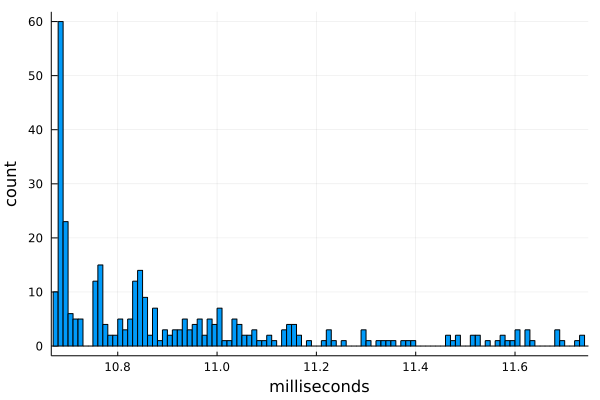

In [18]:
using Statistics # bring in statistical support for standard deviations
t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

# 2. C with -ffast-math

If we allow C to re-arrange the floating point operations, then it'll vectorize with SIMD (single instruction, multiple data) instructions.

In [19]:
const Clib_fastmath = tempname()   # make a temporary file

# The same as above but with a -ffast-math flag added
open(`gcc -fPIC -O3 -msse3 -xc -shared -ffast-math -o $(Clib_fastmath * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum_fastmath(X::Array{Float64}) = ccall(("c_sum", Clib_fastmath), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum_fastmath (generic function with 1 method)

In [20]:
c_fastmath_bench = @benchmark $c_sum_fastmath($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     3.742 ms (0.00% GC)
  median time:      3.874 ms (0.00% GC)
  mean time:        3.945 ms (0.00% GC)
  maximum time:     6.171 ms (0.00% GC)
  --------------
  samples:          1263
  evals/sample:     1

In [21]:
d["C -ffast-math"] = minimum(c_fastmath_bench.times) / 1e6  # in milliseconds

3.742452

# 3. Python's built in `sum` 

The `PyCall` package provides a Julia interface to Python:

In [24]:
# using Pkg; 
Pkg.add("PyCall")
using PyCall

In [25]:
# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [26]:
pysum(a)

4.999782041024689e6

In [27]:
pysum(a) ≈ sum(a)

true

In [28]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 
  memory estimate:  336 bytes
  allocs estimate:  6
  --------------
  minimum time:     545.419 ms (0.00% GC)
  median time:      552.545 ms (0.00% GC)
  mean time:        556.840 ms (0.00% GC)
  maximum time:     579.666 ms (0.00% GC)
  --------------
  samples:          9
  evals/sample:     1

In [29]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any, Any} with 3 entries:
  "C"               => 10.6762
  "Python built-in" => 545.419
  "C -ffast-math"   => 3.74245

# 4. Python: `numpy` 

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [31]:
# using Pkg; 
Pkg.add("Conda")
using Conda

In [32]:
Conda.add("numpy")

┌ Info: Running `conda install -y numpy` in root environment
└ @ Conda /Users/sumit/.julia/packages/Conda/sNGum/src/Conda.jl:128


Solving environment: ...working... done

# All requested packages already installed.



In [33]:
numpy_sum = pyimport("numpy")["sum"]

py_numpy_bench = @benchmark $numpy_sum($a)

BenchmarkTools.Trial: 
  memory estimate:  336 bytes
  allocs estimate:  6
  --------------
  minimum time:     3.890 ms (0.00% GC)
  median time:      3.942 ms (0.00% GC)
  mean time:        4.041 ms (0.00% GC)
  maximum time:     7.397 ms (0.00% GC)
  --------------
  samples:          1234
  evals/sample:     1

In [34]:
numpy_sum(a)

4.999782041024438e6

In [35]:
numpy_sum(a) ≈ sum(a)

true

In [36]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any, Any} with 4 entries:
  "C"               => 10.6762
  "Python numpy"    => 3.88971
  "Python built-in" => 545.419
  "C -ffast-math"   => 3.74245

# 5. Python, hand-written 

In [37]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x7f96d109e9d0>

In [38]:
py_hand = @benchmark $sum_py($a)

BenchmarkTools.Trial: 
  memory estimate:  336 bytes
  allocs estimate:  6
  --------------
  minimum time:     640.417 ms (0.00% GC)
  median time:      652.561 ms (0.00% GC)
  mean time:        655.975 ms (0.00% GC)
  maximum time:     688.704 ms (0.00% GC)
  --------------
  samples:          8
  evals/sample:     1

In [39]:
sum_py(a)

4.999782041024689e6

In [40]:
sum_py(a) ≈ sum(a)

true

In [41]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any, Any} with 5 entries:
  "C"                   => 10.6762
  "Python numpy"        => 3.88971
  "Python hand-written" => 640.417
  "Python built-in"     => 545.419
  "C -ffast-math"       => 3.74245

# 6. Julia (built-in) 

## Written directly in Julia, not in C!

In [42]:
@which sum(a)

sum(a::AbstractArray; dims, kw...) in Base at reducedim.jl:873

In [43]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     4.210 ms (0.00% GC)
  median time:      4.463 ms (0.00% GC)
  mean time:        4.496 ms (0.00% GC)
  maximum time:     6.343 ms (0.00% GC)
  --------------
  samples:          1109
  evals/sample:     1

In [44]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any, Any} with 6 entries:
  "C"                   => 10.6762
  "Python numpy"        => 3.88971
  "Python hand-written" => 640.417
  "Python built-in"     => 545.419
  "Julia built-in"      => 4.21012
  "C -ffast-math"       => 3.74245

# 7. Julia (hand-written) 

In [45]:
function mysum(A)   
    s = 0.0 # s = zero(eltype(a))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [46]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     10.687 ms (0.00% GC)
  median time:      10.851 ms (0.00% GC)
  mean time:        11.088 ms (0.00% GC)
  maximum time:     14.302 ms (0.00% GC)
  --------------
  samples:          451
  evals/sample:     1

In [47]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any, Any} with 7 entries:
  "C"                   => 10.6762
  "Python numpy"        => 3.88971
  "Julia hand-written"  => 10.6865
  "Python hand-written" => 640.417
  "Python built-in"     => 545.419
  "Julia built-in"      => 4.21012
  "C -ffast-math"       => 3.74245

# 8. Julia (hand-written w. simd) 

In [48]:
function mysum_simd(A)   
    s = 0.0 # s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [49]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     4.494 ms (0.00% GC)
  median time:      4.904 ms (0.00% GC)
  mean time:        4.929 ms (0.00% GC)
  maximum time:     6.056 ms (0.00% GC)
  --------------
  samples:          1012
  evals/sample:     1

In [50]:
mysum_simd(a)

4.99978204102443e6

In [51]:
d["Julia hand-written simd"] = minimum(j_bench_hand_simd.times) / 1e6
d

Dict{Any, Any} with 8 entries:
  "Julia hand-written simd" => 4.49392
  "C"                       => 10.6762
  "Python numpy"            => 3.88971
  "Julia hand-written"      => 10.6865
  "Python hand-written"     => 640.417
  "Python built-in"         => 545.419
  "Julia built-in"          => 4.21012
  "C -ffast-math"           => 3.74245

# Summary

In [52]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value; digits=1), 6, "."))
end

C -ffast-math...............3.7
Python numpy................3.9
Julia built-in..............4.2
Julia hand-written simd.....4.5
C..........................10.7
Julia hand-written.........10.7
Python built-in...........545.4
Python hand-written.......640.4
